# Times Series Forecasting with RNNs

A RNN is well suited for times series forecasting because it remembers the past and its decisions are influenced by what it has learned from the past. So, it makes good decisions as data changes. **Time series forecasting** is deploying a model to predict future values based on previously observed values.

Times series data is different than what we have worked with so far because it is a sequence of observations taken sequentially in time. Time series data includes a time dimension, which is an explicit order dependence between observations.

# Components of Time Series

Times series forecasting is predicated upon four 4 constituent parts:

* level - baseline value for the series if it were a straight line
* trend - increasing or decreasing behavior over time
* seasonality - repeating patterns or cycles of behavior over time
* noise - variability in the observations not explained by the model

All time series have a level and most have noise. But, trend and seasonality are optional.

# Weather Forecasting

Forecasting the weather is a difficult and complex endeavor. But, leading edge companies like Google, IBM, Monsanto, and Facebook are leveraging AI technology to realize accurate and timely weather forecasts. Given the introductory nature or our lessons, we cannot hope to demonstrate such complex AI experiments. But, we can show you how to build a simple time series forecasting model using weather data.   

As usual, we need to set up the GPU for each notebook. So, click the **Runtime** tab, click **Change runtime type** from the drop-down menu, choose **GPU** from the Hardware Accelerator drop-down menu, and click **Save**.

In [1]:
import tensorflow as tf

# display tf version and test if GPU is active

tf.__version__, tf.test.gpu_device_name()

('2.3.0', '/device:GPU:0')

# The Weather Dataset

We introduce times series forecasting with RNNs for a univariate problem. We then forecast a multivariate time series. We use weather time series data to train our models. The data is recorded by the Max Planck Institute for Biogeochemistry. Find our more about the institute by perusing the following URL:

https://www.bgc-jena.mpg.de/index.php/Main/HomePage

Let's get the dataset.

In [2]:
import os

p1 = 'https://storage.googleapis.com/tensorflow/'
p2 = 'tf-keras-datasets/jena_climate_2009_2016.csv.zip'
url = p1 + p2

zip_path = tf.keras.utils.get_file(
    origin = url,
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

We use the **splitext()** method to properly extract the CSV file from the URL. We then create an appropriate path for easy loading into Pandas.

Now, we can easily read the CSV file into a Pandas dataframe. 

In [3]:
import pandas as pd

df = pd.read_csv(csv_path)

# Explore the Data


Display the features of the dataframe:

In [4]:
list(df)

['Date Time',
 'p (mbar)',
 'T (degC)',
 'Tpot (K)',
 'Tdew (degC)',
 'rh (%)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'wv (m/s)',
 'max. wv (m/s)',
 'wd (deg)']

Display the first few records:

In [5]:
df.head(3)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


Display the last few records.

In [6]:
df.tail(3)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


We can see that data collection began on January 1, 2009 and ended December 31, 2016. The last data recorded was on January 1, 2017, but it is irrelevant because it is the only recorded piece of data for that year. We can also see that data is recorded every 10 minutes. So, the time step for this experiment is 10 minutes. A **time step** is a single occurrence of an event. Generally, time series forecasting describes predicting the observation at the next time step.

 Continue with a concise summary of the dataframe.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


We see that the dataset contains 14 different features as follows:

* Date Time - date-time reference
* p (mbar) - atmospheric pressure in millibars
* T (degC) - temperature in Celsius
* Tpot (K) - temperature in Kelvin
* Tdew (degC) - temperature in Celsius relative to humidity
* rh (%) - relative humidity
* VPmax (mbar) - saturation vapor pressure in millibars
* VPact (mbar) - vapor pressure in millibars
* VPdef (mbar) - vapor pressure deficit in millibars
* sh (g/kg) - specific humidity in grams per kilogram
* H2OC (mmol/mol) - water vapor concentration in millimoles per mole
* rho (g/m**3) - air density in grams per meter cubed
* wv (m/s) - wind speed in meters per second
* max. wv (m/s) - maximum wind speed in meters per second
* wd (deg) - wind direction in degrees

We also see that there is no missing data. All data is 'float64' except the 'Date Time' object. And, we see that the dataset contains 420,551 rows of data with indexes ranging from 0 to 420550.

Display statistical data:

In [17]:
stats = df.describe()
stats.transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


The **describe** method generates descriptive statistics. The **transpose** method transposes indexes and columns.

Display the shape of the dataframe:

In [18]:
df.shape

(420551, 15)

The dataframe contains 420,551 rows (or records) with 15 features included in each row.

# Plot Relative Humidity Over Time

Since we have the data in a Pandas dataframe, We can easily plot any of the 13 features against *Date Time* time steps. Let's try this with relative humidity represented as **rh (%)**.

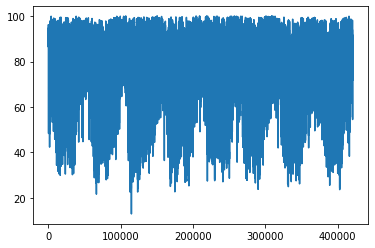

In [19]:
import matplotlib.pyplot as plt

# create new dataframe with just relative humidty column
rh = df['rh (%)']

# plot it!
rh.plot()

From the plot, we see yearly periodicity of relative humidity. Since we have an observation every 10 minutes, each hour has 6 observations. And, each day has 144 (6 observations x 24 hours) observations. 

Let's plot a more narrow view by displaying the first 10 days. Since we have 144 observations per day, we plot a total of 1,440 (10 days x 144 observations/day) observations. Notice that indexing begins a *0*.

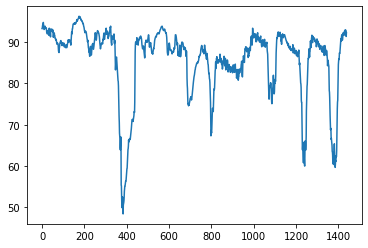

In [20]:
rh10 = df['rh (%)'][0:1439]
rh10.plot()

With a more narrow view of the data, we can see daily periodicity. We also see that fluctuation is pretty chaotic. That is, we don't see a stable pattern.

Explore relative humidity by time step at a granular level:

In [21]:
df[['Date Time','rh (%)']].head()

,Date Time,rh (%)
0,01.01.2009 00:10:00,93.3
1,01.01.2009 00:20:00,93.4
2,01.01.2009 00:30:00,93.9
3,01.01.2009 00:40:00,94.2
4,01.01.2009 00:50:00,94.1


We can do the same exploration by setting an index:

In [22]:
rh_dt = rh
rh_dt.index = df['Date Time']
rh_dt.head()

Date Time
01.01.2009 00:10:00    93.3
01.01.2009 00:20:00    93.4
01.01.2009 00:30:00    93.9
01.01.2009 00:40:00    94.2
01.01.2009 00:50:00    94.1
Name: rh (%), dtype: float64

# Forecast a Univariate Time Series

## Scale Data


Convert dataframe data into numpy arrays.

In [23]:
rh_np = rh.to_numpy()

Scale numpy data for efficient training. Scaling ensures small values on similar scales.

In [24]:
br ='\n'

# original data
print ('first five unscaled observations:', rh_np, br)

# scale relative humidity data
rh_scaled = tf.keras.utils.normalize(rh_np)
print ('shape after tf function:', rh_scaled.shape)

# squeeze out '1' dimension
rh_scaled = tf.squeeze(rh_scaled)
print ('shape after squeeze:', rh_scaled.shape, br)

# convert to numpy
rh_scaled = rh_scaled.numpy()
print ('first five scaled observations:', rh_scaled[:5])

first five unscaled observations: [93.3  93.4  93.9  ... 67.91 71.8  75.7 ] 

shape after tf function: (1, 420551)
shape after squeeze: (420551,) 

first five scaled observations: [0.00184987 0.00185185 0.00186176 0.00186771 0.00186573]


Begin by scaling relative humidity data. Squeeze out the extra *1* dimension added by the TensorFlow function so we can convert the TensorFlow tensor into a numpy array for easier processing. Display the first five scaled observations to verify that scaling worked as planned.

## Establish Training Data Split

In [25]:
import numpy as np

# train split
train_split = int(np.round(df.shape[0] * .75))
train_split

315413

In [26]:
# test split
df.shape[0] - train_split

105138

In [27]:
# calculate number of days of data

print (np.round(train_split / 144, 2))
print (np.round((df.shape[0] - train_split) / 144), 2)

2190.37
730.0 2


For this experiment, use the first 315,413 rows of the data for training and the remaining 105,138 (420,551 - 315,413) rows for the test set. So, training data accounts for about 2,190 (315, 413 / 144) days of data. And, test data accounts for about 730 days of data.

## Split Data into Features and Labels

Create a function that splits the dataset into features and labels.

In [28]:
def create_datasets(data, origin, end, window, target_size):

  # list to hold feature set of windows
  features = []

  # lost to hold labels
  labels = []

  # establish starting point that reflects window size
  origin = origin + window

  # enable split for test data
  if end is None:
    end = len(data) - target_size

  # create feature set of 'window-sized' elements
  for i in range(origin, end):

    # create index set to identify each window
    indices = range(i-window, i)

    # reshape data from (window,) to (window, 1)
    features.append(np.reshape(data[indices], (window, 1)))

    # create labels
    labels.append(data[i+target_size])

  return np.array(features), np.array(labels)

The function accepts a dataset, an index where we want to start, an ending index, the size of each window, and target size. Parameter **window** is the size of the past window of information. The **target_size** is how far in the future we want our model to learn how to predict.

The function continues by creating a list to hold the feature data and another to hold the labels. Next, it establishes the starting point that reflects the window size. To enable creating a test set, the function checks the 'end' value. If it is 'None', the function uses the length of the entire dataset as the ending value so the test set can start where the training set left off up to the ending value.

Once training and test starting points are established, the function creates the feature windows and labels. The *indices* for each feature window is established as the window size. Each subsequent set of *indices* begins where the last set ended. Feature windows are reshaped for TensorFlow consumption and added to the *features* list. Labels are created as the last observation in the next window and then added to the *labels* list. Both features and labels are returned as numpy arrays.

The function may seem confusing, but all it really does is create a dataset that holds relative humidities (for our experiment) and another that holds targets. Targets are based on the last relative humidity from the next window of data. This makes sense because the last relative humidity from the next window is a pretty good prediction of future relative humidity.

So, the feature set becomes a set of windows that contain time step observations. And, the label set contains predictions for each window.

## Create Train and Test Sets

For the train set, we start at index 0 from the dataset and continue up to 315,413. For the test set, we take the remainder. We set the window size to 20 and target to 0.

Invoke the function:

In [29]:
# create train and test sets

import numpy as np

window = 20
target = 0

x_train, y_train = create_datasets(rh_scaled, 0, train_split,
                                   window, target)

x_test, y_test = create_datasets(rh_scaled, train_split, None,
                                 window, target)

Inspect train and test data:

In [30]:
print ('train:', end=' ')
print (x_train.shape, y_train.shape)

print ('test:', end=' ')
print (x_test.shape, y_test.shape)

train: (315393, 20, 1) (315393,)
test: (105118, 20, 1) (105118,)


As expected, the shapes reflect size of each dataset, window size, and the *1* dimension. The *1* dimension indicates that we are making one prediction into the future. We see that the train set contains 315,393 data records composed of windows of 20 relative humidity readings. And, the test set contains 105,118 data records composed of windows of 20 relative humidity readings.

So, why do we have 315,393 training observations instead of the original 315,413? Just subtract the first window of 20 from 315,413. For test data, subtract the first window of 20 from 105,138 to get 105,118.

We can create bigger windows, but this dramatically increases the amount of data we must process. With only 20 observations per window, we already have 6,307,860 (315,393 x 20) data points for training and 2,102,360 (105,118 x 20) data points for testing!

## View Windows of Past History

In [31]:
print ('length of window:', len(x_train[0]), br)
print ('first window of past history:')
print (x_train[0], br)
print ('target relative humidity to predict:')
print (y_train[0])

length of window: 20 

first window of past history:
[[0.00184987]
 [0.00185185]
 [0.00186176]
 [0.00186771]
 [0.00186573]
 [0.00187168]
 [0.00187961]
 [0.00187168]
 [0.00185978]
 [0.0018459 ]
 [0.0018459 ]
 [0.00184788]
 [0.00185383]
 [0.00185383]
 [0.00186176]
 [0.00185582]
 [0.00185383]
 [0.00185383]
 [0.00185383]
 [0.00184987]] 

target relative humidity to predict:
0.0018518500991722392


As expected, the first data window contains 20 relative humidity readings. So, how did we get the target?

Just take the last entry from the next window:

In [32]:
print ('target from the 1st window:', end='   ')
print (np.round(y_train[0], 8))
print ('last obs from the 2nd window:', end=' ')
print (np.round(x_train[1][19][0], 8))

target from the 1st window:   0.00185185
last obs from the 2nd window: 0.00185185


Verify by inspecting the second window:

In [33]:
print ('second window of past history:')
print (x_train[1], br)
print ('target relative humidity to predict:')
print (y_train[1])

second window of past history:
[[0.00185185]
 [0.00186176]
 [0.00186771]
 [0.00186573]
 [0.00187168]
 [0.00187961]
 [0.00187168]
 [0.00185978]
 [0.0018459 ]
 [0.0018459 ]
 [0.00184788]
 [0.00185383]
 [0.00185383]
 [0.00186176]
 [0.00185582]
 [0.00185383]
 [0.00185383]
 [0.00185383]
 [0.00184987]
 [0.00185185]] 

target relative humidity to predict:
0.0018459019725153689


Let's see if this pattern holds for the second and third windows:

In [34]:
print ('target from the 2nd window:', end='   ')
print (np.round(y_train[1], 8))
print ('last obs from the 3rd window:', end=' ')
print (np.round(x_train[2][19][0], 8), br)

print ('target from the 3rd window:', end='   ')
print (np.round(y_train[2], 8))
print ('last obs from the 4th window:', end=' ')
print (np.round(x_train[3][19][0], 8))

target from the 2nd window:   0.0018459
last obs from the 3rd window: 0.0018459 

target from the 3rd window:   0.00183202
last obs from the 4th window: 0.00183202


Just to be sure, inspect the pattern for the fourth and fifth windows:

In [35]:
print ('target from the 4th window:', end='   ')
print (np.round(y_train[3], 8))
print ('last obs from the fifth window:', end=' ')
print (np.round(x_train[4][19][0], 8), br)

print ('target from the 5th window:', end='   ')
print (np.round(y_train[4], 8))
print ('last obs from the 6th window:', end=' ')
print (np.round(x_train[5][19][0], 8))

target from the 4th window:   0.00183599
last obs from the fifth window: 0.00183599 

target from the 5th window:   0.00182806
last obs from the 6th window: 0.00182806


## Plot Single Example

Create a function that returns a list of timesteps beginning at *-length* to *0*.

In [36]:
def create_time_steps(length):
  return list(range(-length, 0))

Create another function that accepts a single data window and its associated target, delta, and a title. Parameter **delta** is used to indicate a variation in a variable. The function plots each element in the data window with its associated time step.

In [39]:
def plot(plot_data, delta=0, title='Data Window'):  
  labels = ['history', 'actual future', 'model prediction']
  marker = ['r.-', 'b*', 'g>']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta: future = delta
  else: future = 0
  plt.title(title)
  for i, obs in enumerate(plot_data):
    if i:
      plt.plot(future, obs, marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, obs.flatten(), marker[i],
               label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('time step')
  return plt

Invoke the function based on the first data window and target from the train set:

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

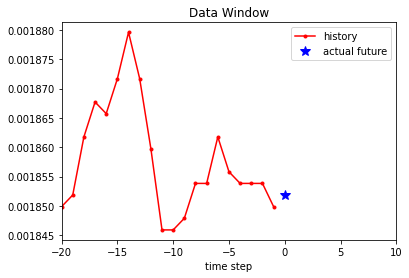

In [40]:
plot([x_train[0], y_train[0]])

We assume that delta is 0. It looks like our trend is pretty good, but we shouldn't get overconfident since relative humidity doesn't fluctuate wildy from one time step to the next. Actually, we set up our data this way because we created creating targets based on the last entry of the next window.

## Create a Visual Performance Baseline

Before training our model, it is a good idea to create a simple visual performance baseline to compare against model performance. Of course, there are many ways to do this, but a very simple way is to use the average of the last 20 observations.

 Create a function that returns the average of a window of observations:

In [41]:
def baseline(history):
  return np.mean(history)

Plot the first data window adding our baseline prediction.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

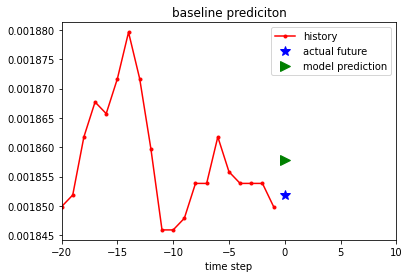

In [42]:
plot([x_train[0], y_train[0], baseline(x_train[0])], 0,
     'baseline prediciton')

Now, we have a visual baseline to compare against our model.

## Create a Baseline Metric

It's also a good idea to create a metric for the baseline. We can then numerically compare our model against the baseline metric. The simplest approach is to predict the last value for each window. We can then find the average mean squared error of the predictions and use this value as our metric.

In [43]:
# display shape of test set
print ('TensorFlow shape:', x_test[0].shape, br)

# remove '1' dimension for easier processing
x_test_np = tf.squeeze(x_test)
print ('numpy shape:', x_test_np[0].shape, br)

# predict last value for each window
y_pred = x_test_np[:, -1]

# compute average MSE
MSE = np.mean(tf.keras.losses.mean_squared_error(y_test, y_pred))
print ('MSE:', MSE)

TensorFlow shape: (20, 1) 

numpy shape: (20,) 

MSE: 5.93914036657917e-10


Wow! The MSE is very small, which means that our baseline metric might be hard to beat. Why? In general, machine learning has a pretty significant limitation. Unless the learning algorithm is hardcoded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem. Our time series problem is really a very simple problem.

## RNN Forecasting Model

A RNN is well-suited to time series data because its layers can provide feedback to earlier layers. Specifically, a RNN processes time series data time step by time step while remembering information it sees during training. Our model uses a GRU layer, which is a specialized RNN layer capable of remembering information over long periods of time. So, it is well-suited for time series modeling.

## Finish the Input Pipeline

 Shuffle (where appropriate), batch, and cache:

In [46]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

# prepare the train set
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_one = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# prepare the test set
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_one = test.batch(BATCH_SIZE).repeat()

Inspect tensors:

In [47]:
train_one, test_one

(<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>,
 <RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>)

## Explore a Data Window

Verify that features and labels are batched in 256 element windows:

In [48]:
for feature, label in train_one.take(1):
  print (len(feature), len(label))

256 256


Display the first window from the first batch:

In [49]:
for feature, label in train_one.take(1):
  print ('feature:')
  print (feature[0].numpy(), br)
  print ('label:', label[0].numpy())

feature:
[[0.00125486]
 [0.00124474]
 [0.00121064]
 [0.00118209]
 [0.0011696 ]
 [0.00120687]
 [0.00124237]
 [0.00125803]
 [0.00126556]
 [0.00128638]
 [0.00130621]
 [0.00132921]
 [0.00135578]
 [0.00137263]
 [0.00138234]
 [0.00138988]
 [0.00141367]
 [0.00143548]
 [0.00145531]
 [0.00147514]] 

label: 0.0015068587530737705


As expected, the first window contains a feature set with 20 observations and a label with 1 prediction.

## Create the Model

Import requisite libraries and clear any previous model sessions:

In [50]:
# clear any previous models

tf.keras.backend.clear_session()

#import libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

Establish the input shape:

In [51]:
input_shape = x_train.shape[-2:]
input_shape

(20, 1)

All is well because our input shape shows window size of 20 and includes the *1* dimension that shows that we are making a single prediction.

Plant a seed for reproducibility and create the model:

In [52]:
# set seed to ensure reproducibility
tf.random.set_seed(0)

neurons = 32  # number of neurons in GRU layer

model = Sequential([
  GRU(neurons, input_shape=input_shape),
  Dense(1)
])

## Model Summary

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3360      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


3 x (32 squared + 32 + 2 * 32)

## Verify that the Model Output is Correct

Make an untrained prediction from the model:

In [54]:
for x, y in test_one.take(1):
  print(model.predict(x).shape)

(256, 1)


The prediction shows batch size of 256 and 1. So, output of our model is working as expected.

## Compile the Model

In [55]:
model.compile(optimizer='adam', loss='mse')

# Train the Model

In [56]:
num_train_steps = 400
epochs = 10

history = model.fit(train_one, epochs=epochs,
                    steps_per_epoch=num_train_steps,
                    validation_data=test_one, validation_steps=50)

Epoch 1/10
400/400 [==============================] - 2s 4ms/step - loss: 1.1659e-06 - val_loss: 2.0402e-08
Epoch 2/10
400/400 [==============================] - 1s 3ms/step - loss: 2.1958e-08 - val_loss: 1.1275e-08
Epoch 3/10
400/400 [==============================] - 1s 3ms/step - loss: 1.2079e-08 - val_loss: 5.9204e-09
Epoch 4/10
400/400 [==============================] - 1s 3ms/step - loss: 6.8642e-09 - val_loss: 3.2195e-09
Epoch 5/10
400/400 [==============================] - 1s 3ms/step - loss: 1.3179e-08 - val_loss: 1.6071e-08
Epoch 6/10
400/400 [==============================] - 1s 3ms/step - loss: 3.3547e-08 - val_loss: 9.6983e-09
Epoch 7/10
400/400 [==============================] - 1s 3ms/step - loss: 3.8275e-08 - val_loss: 1.1762e-07
Epoch 8/10
400/400 [==============================] - 1s 3ms/step - loss: 3.3392e-08 - val_loss: 1.7163e-09
Epoch 9/10
400/400 [==============================] - 1s 3ms/step - loss: 3.3516e-08 - val_loss: 5.1894e-08
Epoch 10/10
400/400 [=======

## Generalize on Test Data

In [57]:
test_loss = model.evaluate(test_one, steps=num_train_steps)

400/400 [==============================] - 1s 2ms/step - loss: 1.1678e-08


## Make Predictions

Make as many predictions as you wish, but we limit the number of predictions to *3* for demonstration purposes. 

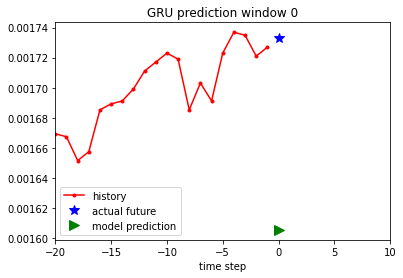

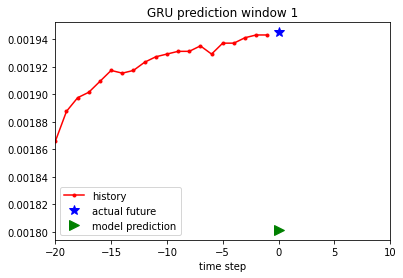

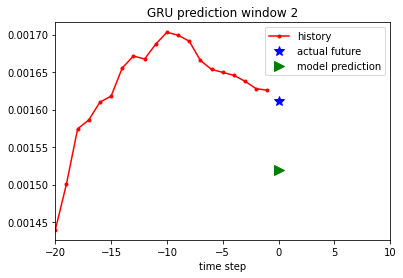

In [58]:
n = 3
title = 'GRU prediction'

for i, (x, y) in enumerate(test_one.take(n)):
  p = model.predict(x)[0]
  plot([x[0].numpy(), y[0].numpy(), p], 0,
       title + ' window ' + str(i))
  plt.show()

Visually, it doesn't appear that our model is predicting very well. But, the number range on the x-axis is very granular.

## Plot Model Performance

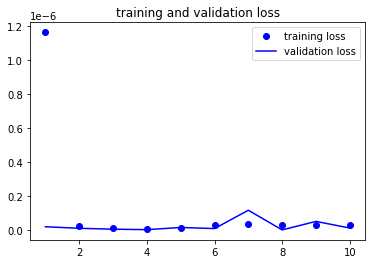

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

Voilà! Our model looks pretty good!

# Forecast a Multivariate Time Series

We just demonstrated how to forecast a single variable. Now, let's see how to forecast based on more than one variable. We can choose any of the 13 features (we don't want to predict from the timestep feature) from the DataFrame, but let's just look at three. Namely, 'Tdew (degC)', 'sh (g/kg)', and 'H2OC (mmol/mol)'. **Tdew (degC)** is the temperature in Celsius relative to humidity. **sh (g/kg)** is the specific humidity in grams per kilogram. **H2OC (mmol/mol)** is the water vapor concentration in millimoles per mole. And, **rho (g/m**3)** is the air density in grams per meter cubed.

Let's create a variable to hold the features that we wish to consider for our multivariate time series experiment.

In [76]:
mv_features = ['Tdew (degC)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)']

In [62]:
mv_features = ['Tdew (degC)', 'sh (g/kg)', 'H2OC (mmol/mol)']

Now, let's create a new DataFrame.

In [77]:
mv_features = df[mv_features]
mv_features.index = df['Date Time']
mv_features.head()

,Tdew (degC),sh (g/kg),H2OC (mmol/mol),rho (g/m**3)
Date Time,,,,
01.01.2009 00:10:00,-8.90,1.94,3.12,1307.75
01.01.2009 00:20:00,-9.28,1.89,3.03,1309.80
01.01.2009 00:30:00,-9.31,1.88,3.02,1310.24
01.01.2009 00:40:00,-9.07,1.92,3.08,1309.19
01.01.2009 00:50:00,-9.04,1.92,3.09,1309.00


Pandas offers a very easy way to visualize. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb0d32d4e0>,
      dtype=object)

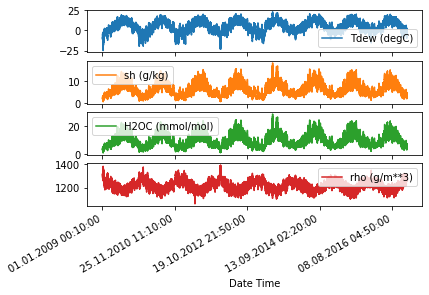

In [78]:
mv_features.plot(subplots=True)

We can also visualize a single feature.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb0e488ef0>],
      dtype=object)

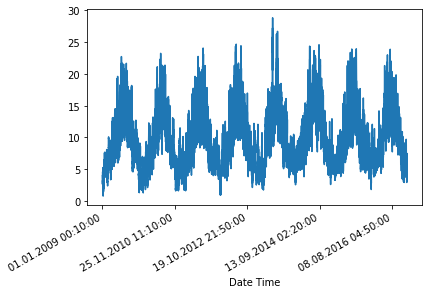

In [79]:
mv_features['H2OC (mmol/mol)'].plot(subplots=True)

# Scale Data for TensorFlow Consumption

First, convert DataFrame to numpy arrays.

In [80]:
# convert DataFrame to numpy arrays

f_np = mv_features.to_numpy()
f_np[:5]

array([[  -8.9 ,    1.94,    3.12, 1307.75],
       [  -9.28,    1.89,    3.03, 1309.8 ],
       [  -9.31,    1.88,    3.02, 1310.24],
       [  -9.07,    1.92,    3.08, 1309.19],
       [  -9.04,    1.92,    3.09, 1309.  ]])

Let's see how many observations are in the dataset.

In [81]:
len(f_np)

420551

As expected, we have 420,551 observations.

Next, scale data and convert back to numpy arrays for easier processing.

In [82]:
# scale features
f_scaled = tf.keras.utils.normalize(f_np)
print ('shape after tf function:', f_scaled.shape, br)

# squeeze
f_scaled = tf.squeeze(f_scaled)

# convert to numpy
f_scaled = f_scaled.numpy()
print ('first five scaled observation:', f_scaled[:5])

shape after tf function: (420551, 4) 

first five scaled observation: [[-0.0068054   0.00148342  0.00238571  0.9999729 ]
 [-0.00708485  0.00144293  0.00231326  0.99997119]
 [-0.00710536  0.00143481  0.00230485  0.99997107]
 [-0.00692775  0.00146651  0.00235253  0.99997216]
 [-0.00690584  0.00146673  0.00236052  0.99997229]]


# Multi-Step Model

With relative humidity, we only predicted a single future point. But, we can create a model to learn to predict a range of future values, which is what we are going to do with the multivariate data we just established.

Let's say that we want to train our multi-step model to learn to predict for the next 12 hours. Since our data time steps are 10 minutes (1 observation every 10 minutes), there are 6 observations every hour. Given that we want to predict for the next 12 hours, our model makes 72 (6 obs x 12) predictions.

Let's also say that we want to show our model data from the last five (5) days for each sample. Since there are 24 hours in a day, we have 144 (6 x 24) observations each day. So, we have a total of 720 (5 x 144) observations. But, we want to sample every hour because we don't expect a drastic change in any of our features within 60 minutes. Thus, 120 (720 obs / 6 obs per hour) observations represents each window of data.

## Generators

Since we are training multiple features to predict a range of future values, we create a generator function to create train and test splits. A **generator** is a function that returns an object iterator that we can iterate over one value at a time. A generator is defined like a normal function, but it generates a value with the *yield* keyword rather than *return*. So, adding the yield keyword automatically makes a function a generator.

Generators are easy to implement, but a bit difficult to understand. We can invoke a generator in the same way as a regular function. But, when we invoke it a generator object is created. We must iterate over the generator object to see its contents. As we iterate over the generator object, all processes withing the function are processed until it reaches a 'yield' statement. Once this happens, the generator yields a new value from its contents and returns execution back to the 'for' loop. So, a generator yields one element from its contents for each cycle of a loop.

## Advantages of Using a Generator

Generator functions allow us to declare a function that behaves like an iterator. So, we can make iterators in a fast, easy, and clean way. An **iterator** is an object that can be iterated upon. It is used to abstract a container of data to make it behave like an iterable object. As programmers, we use iterable objects like strings, lists, and dictionaries frequently.

Generators save memory space because they don’t compute the value of each item when instantiated. Generators only compute a value when explicity asked to do so. Such behavior is known as **lazy evaluation**. Lazy evaluation is useful when we process large datasets because it allows us to start using data immediately rather than having to wait until the entire dataset is processed.

## Generator Caveats

* A generatore creates a single object. So, a generator object can only be assigned to a single variable no matter how many values it yields.
* Once iterated over, a generator is extinguished. So, it must be rerun to be repopulated.

## Create a Generator Function

In [83]:
def generator(d, t, o, e, w, ts, s):

  # hold features and labels
  features, labels = [], []

  # initialize variables
  data, target = d, t
  origin, end = o, e
  window, target_size = w, ts
  step = s

  # establish starting point that reflects window size
  origin = origin + window

  # enable split for test data
  if end < 0:
    end = len(data) - target_size

  # create feature set of 'window-sized' elements
  for i in range(origin, end):

    # create index set to identify each window
    indices = range(i-window, i, step)

    # create features
    features.append(data[indices])

    # create labels
    labels.append(target[i:i+target_size])

  yield np.array(features), np.array(labels)

## Generate Train and Test Data

Now, let's invoke the generator to create train and test sets. Notice that we assign the generator object to a single variable!

In [84]:
window = 720  # observations for 5 days
future_target = 72  # predictions for the next 12 hours
step = 6  # number of timesteps per hour

train_gen = generator(f_scaled, f_scaled[:, 1], 0, train_split,
                      window, future_target, step)

test_gen = generator(f_scaled, f_scaled[:, 1], train_split, -1,
                     window, future_target, step)

Wow! Notice how much faster the generator creates the data sets.

# Reconstitute Generated Tensors

Remake the generated data into numpy arrays. Begin with the train data by iterating the generator and creating train and test lists. 

In [85]:
train_f, train_l = [], []
for i, row in enumerate(train_gen):
  train_f.append(row[0])
  train_l.append(row[1])

Convert list data to numpy arrays:

In [86]:
train_features = np.asarray(train_f, dtype=np.float64)
train_labels = np.asarray(train_l, dtype=np.float64)

Inspect shapes:

In [87]:
train_features.shape, train_labels.shape

((1, 314693, 120, 4), (1, 314693, 72))

Remove the *1* dimension with the *tf.squeeze* function.

In [88]:
train_features, train_labels = tf.squeeze(train_features), tf.squeeze(train_labels)
train_features.shape, train_labels.shape

(TensorShape([314693, 120, 4]), TensorShape([314693, 72]))

Reconstitute test data:

In [89]:
# create test data
test_f, test_l = [], []
for i, row in enumerate(test_gen):
  test_f.append(row[0])
  test_l.append(row[1])

# convert lists to numpy arrays
test_features = np.asarray(test_f, dtype=np.float64)
test_labels = np.asarray(test_l, dtype=np.float64)

# squeeze out the '1' dimension created by the generator
test_features, test_labels = tf.squeeze(test_features), tf.squeeze(test_labels)
test_features.shape, test_labels.shape

(TensorShape([104346, 120, 4]), TensorShape([104346, 72]))

## Finish the Input Pipeline

In [92]:
train_mv = tf.data.Dataset.from_tensor_slices(
    (train_features, train_labels))
train_mv = train_mv.cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_mv = tf.data.Dataset.from_tensor_slices(
    (test_features, test_labels))
test_mv = test_mv.batch(BATCH_SIZE).repeat()

Check tensors:

In [93]:
train_mv, test_mv

(<RepeatDataset shapes: ((None, 120, 4), (None, 72)), types: (tf.float64, tf.float64)>,
 <RepeatDataset shapes: ((None, 120, 4), (None, 72)), types: (tf.float64, tf.float64)>)

Check a batch:

In [94]:
for item in train_mv.take(1):
  print (item[0].shape)
  print (item[1].shape)

(256, 120, 4)
(256, 72)


So, each batch contains 256 items. Each item has both feature sets and labels. Each feature set is a window of 120 observations where each observation contains 4 features. Each label contains 72 predictions.

Establish input shape:

In [95]:
input_shape_multi = item[0].shape[-2:]
input_shape_multi

TensorShape([120, 4])

## Create the Model

In [96]:
# clear any previous models
tf.keras.backend.clear_session()


# set seed to ensure reproducibility
tf.random.set_seed(0)

neurons = 32  # neurons in GRU layer
outputs = 72

gen_model = Sequential([
  GRU(neurons, input_shape=input_shape_multi),
  Dense(outputs)
])

## Model Summary

In [97]:
gen_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3648      
_________________________________________________________________
dense (Dense)                (None, 72)                2376      
Total params: 6,024
Trainable params: 6,024
Non-trainable params: 0
_________________________________________________________________


## Compile the Model

In [98]:
gen_model.compile(optimizer='adam', loss='mse')

## Train the Model

In [99]:
num_train_steps = 400
epochs = 10

gen_history = gen_model.fit(train_mv, epochs=epochs,
                            steps_per_epoch=num_train_steps,
                            validation_data=test_mv,
                            validation_steps=50)

Epoch 1/10
400/400 [==============================] - 4s 9ms/step - loss: 3.6479e-04 - val_loss: 5.2611e-07
Epoch 2/10
400/400 [==============================] - 4s 9ms/step - loss: 3.1158e-06 - val_loss: 7.5770e-07
Epoch 3/10
400/400 [==============================] - 4s 10ms/step - loss: 2.3610e-06 - val_loss: 1.9507e-06
Epoch 4/10
400/400 [==============================] - 3s 8ms/step - loss: 1.6071e-06 - val_loss: 6.3563e-07
Epoch 5/10
400/400 [==============================] - 3s 8ms/step - loss: 1.2162e-06 - val_loss: 7.2377e-07
Epoch 6/10
400/400 [==============================] - 3s 8ms/step - loss: 8.5188e-07 - val_loss: 9.5920e-07
Epoch 7/10
400/400 [==============================] - 3s 8ms/step - loss: 7.0101e-07 - val_loss: 5.2487e-07
Epoch 8/10
400/400 [==============================] - 3s 8ms/step - loss: 7.0191e-07 - val_loss: 4.9559e-07
Epoch 9/10
400/400 [==============================] - 3s 8ms/step - loss: 6.0076e-07 - val_loss: 4.5978e-07
Epoch 10/10
400/400 [======

## Generalize on Test Data

In [100]:
test_loss = gen_model.evaluate(test_mv, steps=num_train_steps)

400/400 [==============================] - 2s 4ms/step - loss: 6.7919e-07


## Plot Performance

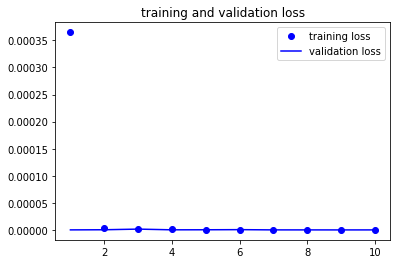

In [101]:
loss = gen_history.history['loss']
val_loss = gen_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

## Plot a Data Window

Create a plotting function:

In [102]:
def multi_step_plot(window, true_future, pred):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(window))
  num_out = len(true_future)

  plt.plot(num_in, np.array(window[:, 1]), 'm', label='history')
  plt.plot(np.arange(num_out)/step, np.array(true_future), 'bo',
           label='true future')
  if pred.any():
    plt.plot(np.arange(num_out)/step, np.array(pred), 'go',
             label='predicted future')
  plt.legend(loc='upper left')
  plt.show()

Plot the first training window from the first batch:

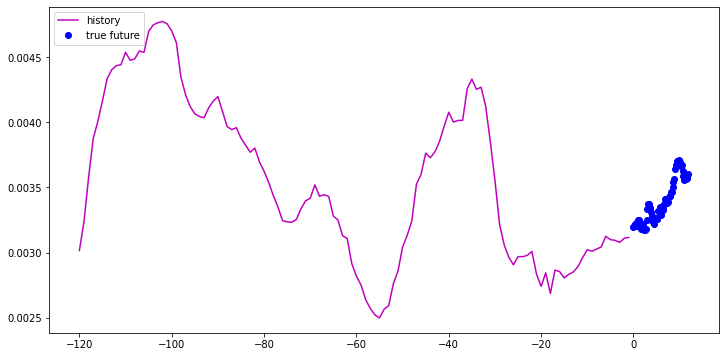

In [103]:
# plot first 'Tdew (degC)' window

for x, y in train_mv.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

## Make a Prediction

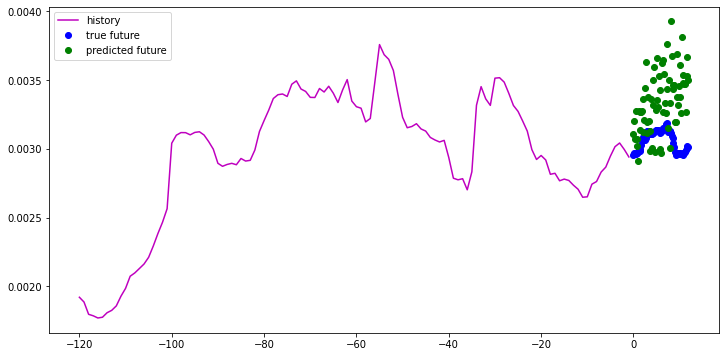

In [105]:
for x, y in test_mv.take(1):
  y_pred = gen_model.predict(x)[0]
  multi_step_plot(x[0], y[0], y_pred)

Not bad.